# SI 370 Final Project - MLB All-Stars: Who was Snubbed?

## By Ryan Simon, Abe Winer, and Jack Basner

### -----------------------------------------------------------------------------------------------------

# Download and Import Libraries

In [ ]:
%pip install pybaseball==2.2.7


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install shap==0.43.0


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install statsmodels==0.14.0


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pybaseball import batting_stats_range
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load Datasets

Reading in data for all players that played in 2019-2023 (excluding the shortened COVID season of 2020), focusing on advanced sabermetrics (woba, babip, iso, etc.) in the "all_players_..." dataframes and more basic metrics (batting average, hits, home runs, OPS, etc.) in the "batting_stats_..." dataframes.

In [ ]:
all_players_2023 = pd.read_csv('all_players_2023.csv')
all_players_2022 = pd.read_csv('all_players_2022.csv')
all_players_2021 = pd.read_csv('all_players_2021.csv')
all_players_2019 = pd.read_csv('all_players_2019.csv')

In [ ]:
batting_stats_2023 = batting_stats_range('2023-03-30', '2023-07-11')

In [ ]:
batting_stats_2022 = batting_stats_range('2022-04-07', '2022-07-19')

In [ ]:
batting_stats_2021 = batting_stats_range('2021-04-01', '2021-07-13')

In [ ]:
# If "IndexError: list index out of range" occurs, simply run again and it will go through
batting_stats_2019 = batting_stats_range('2019-03-28', '2019-07-09')

In [ ]:
all_players_2019.head()

,pitches,player_id,player_name,total_pitches,pitch_percent,ba,iso,babip,slg,woba,...,release_extension,pos3_int_start_distance,pos4_int_start_distance,pos5_int_start_distance,pos6_int_start_distance,pos7_int_start_distance,pos8_int_start_distance,pos9_int_start_distance,pitcher_run_exp,run_exp
0,1804,656555,"Hoskins, Rhys",3223,56.0,0.263,0.267,0.309,0.530,0.389,...,6.05,108,152,118,145,303,328,302,-20.7,20.7
1,1780,660670,"Acuña Jr., Ronald",3048,58.4,0.292,0.214,0.346,0.506,0.372,...,6.02,109,152,116,147,312,329,298,-24.8,24.8
2,1756,605141,"Betts, Mookie",2909,60.4,0.272,0.194,0.295,0.467,0.364,...,5.99,107,151,119,145,294,327,301,-18.3,18.3
3,1687,543760,"Semien, Marcus",2965,56.9,0.271,0.178,0.286,0.448,0.339,...,5.94,108,151,114,145,301,320,289,-10.6,10.6
4,1666,608324,"Bregman, Alex",2915,57.2,0.265,0.268,0.245,0.533,0.387,...,5.96,106,151,117,145,296,326,292,-18.5,18.5


In [ ]:
batting_stats_2023.head()

,Name,Age,#days,Lev,Tm,G,PA,AB,R,H,...,SH,SF,GDP,SB,CS,BA,OBP,SLG,OPS,mlbID
1,CJ Abrams,22,142,Maj-NL,Washington,81,302,282,35,69,...,1,0,5,14,2,0.245,0.292,0.397,0.690,682928
2,Jos\xc3\xa9 Abreu,36,142,Maj-AL,Houston,87,364,334,29,79,...,0,5,11,0,1,0.237,0.286,0.344,0.630,547989
3,Ronald Acuna Jr.,25,142,Maj-NL,Atlanta,89,409,359,79,119,...,0,2,7,40,7,0.332,0.408,0.582,0.991,660670
4,Willy Adames,27,142,Maj-NL,Milwaukee,81,349,305,40,65,...,0,5,8,4,2,0.213,0.294,0.416,0.710,642715
5,Riley Adams,27,144,Maj-NL,Washington,22,83,75,4,20,...,1,0,4,0,0,0.267,0.329,0.507,0.836,656180


Reading in data listing the players who were all stars in a particular season

In [ ]:
all_star_2023 = pd.read_csv('all_stars_2023.csv')
all_star_2022 = pd.read_csv('all_stars_2022.csv')
all_star_2021 = pd.read_csv('all_stars_2021.csv')
all_star_2019 = pd.read_csv('all_stars_2019.csv')
all_star_2019.head()

,Year,Player,Position
0,2019,Christian Yelich,LF
1,2019,Javier Báez,SS
2,2019,Freddie Freeman,1B
3,2019,Cody Bellinger,RF
4,2019,Nolan Arenado,3B


# Data Manipulation

To make the player names easier to work with, they were process to alter how they are displayed. For instance, the player names were originally "last_name, first_name", but the following code altered them to have the structure of "first_name last_name"

In [ ]:
all_players_2023['player_name'] = all_players_2023['player_name'].apply(lambda x: ' '.join(x.split(', ')[::-1]))
all_players_2022['player_name'] = all_players_2022['player_name'].apply(lambda x: ' '.join(x.split(', ')[::-1]))
all_players_2021['player_name'] = all_players_2021['player_name'].apply(lambda x: ' '.join(x.split(', ')[::-1]))
all_players_2019['player_name'] = all_players_2019['player_name'].apply(lambda x: ' '.join(x.split(', ')[::-1]))
all_players_2023['player_name']

0          Matt Olson
1      Nathaniel Lowe
2      Jonathan India
3            Ian Happ
4       Brandon Nimmo
            ...      
566        Chris Okey
567      Tres Barrera
568    Michael Fulmer
569        Josh Sborz
570     Shelby Miller
Name: player_name, Length: 571, dtype: object

To ensure consistency, Ronald Acuña Jr.'s name in the all_star dataframes needed to be adjusted to include the "ñ", as it had it in the all_players dataframes.

The names of the players were adjusted to be formatted as "first_name_last name" like before, and a binary of "1" was applied in a ne column to show they are all_stars.

In [ ]:
all_star_2023.at[0, 'Player'] = 'Ronald Acuña Jr.'
all_star_2022.at[42, 'Player'] = 'Ronald Acuña Jr.'
all_star_2021.at[71, 'Player'] = 'Ronald Acuña Jr.'

all_star_list = [all_star_2023, all_star_2022, all_star_2021, all_star_2019]
for i in range(len(all_star_list)):
    all_star_list[i] = all_star_list[i].dropna()
    c = all_star_list[i].copy()
    c.loc[:,'name_split'] = c.Player.apply(lambda x: x.split(' ', 1))
    c['player_name'] = c.name_split.apply(lambda x: x[0] + ' ' + x[1])
    c = c.drop(columns=['Player', 'name_split'])
    c['all_star'] = 1
    all_star_list[i] = c

all_star_2023 = all_star_list[0]
all_star_2022 = all_star_list[1]
all_star_2021 = all_star_list[2]
all_star_2019 = all_star_list[3]
all_star_2019

,Year,Position,player_name,all_star
0,2019,LF,Christian Yelich,1
1,2019,SS,Javier Báez,1
2,2019,1B,Freddie Freeman,1
3,2019,RF,Cody Bellinger,1
4,2019,3B,Nolan Arenado,1
...,...,...,...,...
77,2019,P,Charlie Morton,1
78,2019,P,Jake Odorizzi,1
79,2019,P,Ryan Pressly,1
80,2019,P,Marcus Stroman,1


Excluded pitchers, as we are only focusing on hitting statistics in this analysis, and pitchers are notorious for being the worst hitting position as they spend their practice time on pitching, it being their main focus after all.

In [ ]:
all_star_2019 = all_star_2019[all_star_2019.Position!='P']

In [ ]:
more_stats_2023 = batting_stats_2023.copy()
more_stats_2022 = batting_stats_2022.copy()
more_stats_2021 = batting_stats_2021.copy()
more_stats_2019 = batting_stats_2019.copy()

Merge all statistics together to create master dataframe with all basic and advanced sabermetrics for each season.

In [ ]:
merged_2023 = all_players_2023.merge(more_stats_2023, left_on = 'player_id', right_on = 'mlbID')
merged_2022 = all_players_2022.merge(more_stats_2022, left_on = 'player_id', right_on = 'mlbID')
merged_2021 = all_players_2021.merge(more_stats_2021, left_on = 'player_id', right_on = 'mlbID')
merged_2019 = all_players_2019.merge(more_stats_2019, left_on = 'player_id', right_on = 'mlbID')

In [ ]:
final_2023 = merged_2023.merge(all_star_2023, on = 'player_name', how = 'left')
final_2023.Year.fillna(2023, inplace=True)
final_2022 = merged_2022.merge(all_star_2022, on = 'player_name', how = 'left')
final_2022.Year.fillna(2022, inplace=True)
final_2021 = merged_2021.merge(all_star_2021, on = 'player_name', how = 'left')
final_2021.Year.fillna(2021, inplace=True)
final_2019 = merged_2019.merge(all_star_2019, on = 'player_name', how = 'left')
final_2019.Year.fillna(2019, inplace=True)
final = pd.concat([final_2023, final_2022, final_2021, final_2019])
final.head()

,pitches,player_id,player_name,total_pitches,pitch_percent,ba,iso,babip,slg,woba,...,SB,CS,BA,OBP,SLG,OPS,mlbID,Year,Position,all_star
0,1723,621566,Matt Olson,3092,55.7,0.254,0.315,0.280,0.569,0.388,...,1,0,0.254,0.358,0.569,0.926,621566,2023.0,1B,1.0
1,1680,663993,Nathaniel Lowe,3044,55.2,0.270,0.152,0.327,0.421,0.341,...,0,0,0.270,0.360,0.421,0.781,663993,2023.0,NaN,NaN
2,1650,663697,Jonathan India,2205,74.8,0.250,0.161,0.280,0.411,0.329,...,12,2,0.250,0.339,0.411,0.750,663697,2023.0,NaN,NaN
3,1644,664023,Ian Happ,2862,57.4,0.247,0.140,0.329,0.386,0.340,...,7,2,0.247,0.377,0.386,0.763,664023,2023.0,NaN,NaN
4,1640,607043,Brandon Nimmo,2847,57.6,0.267,0.176,0.325,0.443,0.353,...,3,1,0.266,0.365,0.442,0.807,607043,2023.0,NaN,NaN


Only including the variables that we feel are necessary

In [ ]:
final = final[['player_id', 'player_name', 'iso', 'babip', 'woba', 'xwoba', 'xba', 'whiffs', 'swings', 'takes', 
               'Age', 'Tm', 'Lev', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'SO', 'HBP', 'SH', 'SF', 
               'GDP', 'SB', 'CS', 'BA', 'OBP', 'SLG', 'OPS', 'Year', 'all_star']]

In [ ]:
final.all_star.fillna(0, inplace = True)

In [ ]:
final = final.dropna()

Dataset that has the abbreviation for each of the 30 MLB teams

In [ ]:
abbreviations = pd.read_csv('abbreviations.csv')
abbreviations = abbreviations.set_index('Tm')

In [ ]:
abbreviations = abbreviations.to_dict()

Helper function to give correct team abbreviation

In [ ]:
def abbr(row):
    if row['Tm'] not in abbreviations['Abbr']:
        new_team = row['Tm'].split(',')[0]
        team = abbreviations['Abbr'][new_team]
        return team
    if row['Lev'] == 'Maj-AL':
        abbreviations['Abbr']['Los Angeles'] = 'LAA'
        abbreviations['Abbr']['New York'] = 'NYY'
        abbreviations['Abbr']['Chicago'] = 'CHW'
    elif row['Lev'] == 'Maj-NL':
        abbreviations['Abbr']['Los Angeles'] = 'LAD'
        abbreviations['Abbr']['New York'] = 'NYM'
        abbreviations['Abbr']['Chicago'] = 'CHC'
    team = abbreviations['Abbr'][row['Tm']]
    return team

In [ ]:
final['abbr'] = final.apply(abbr, axis=1)

Making the 'Year" variable a categorical variable and making "all_star" a boolean value

In [ ]:
final['Year'] = final['Year'].astype(int)
final['Year'] = final['Year'].apply(lambda x: str(x))
final['all_star'] = final['all_star'].apply(lambda x: True if x==1 else False)
final['Year']

0      2023
1      2023
2      2023
3      2023
4      2023
       ... 
354    2019
355    2019
356    2019
357    2019
358    2019
Name: Year, Length: 1885, dtype: object

In [ ]:
final.head()

,player_id,player_name,iso,babip,woba,xwoba,xba,whiffs,swings,takes,...,GDP,SB,CS,BA,OBP,SLG,OPS,Year,all_star,abbr
0,621566,Matt Olson,0.315,0.280,0.388,0.390,0.253,259,829,894,...,8,1,0,0.254,0.358,0.569,0.926,2023,True,ATL
1,663993,Nathaniel Lowe,0.152,0.327,0.341,0.341,0.269,147,740,940,...,11,0,0,0.270,0.360,0.421,0.781,2023,False,TEX
2,663697,Jonathan India,0.161,0.280,0.329,0.343,0.253,135,655,995,...,11,12,2,0.250,0.339,0.411,0.750,2023,False,CIN
3,664023,Ian Happ,0.140,0.329,0.340,0.343,0.241,191,726,917,...,6,7,2,0.247,0.377,0.386,0.763,2023,False,CHC
4,607043,Brandon Nimmo,0.176,0.325,0.353,0.352,0.257,170,698,942,...,2,3,1,0.266,0.365,0.442,0.807,2023,False,NYM


# Exploratory Data Analysis

## Summary Statistics

In [ ]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1885 entries, 0 to 358
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   player_id    1885 non-null   int64  
 1   player_name  1885 non-null   object 
 2   iso          1885 non-null   float64
 3   babip        1885 non-null   float64
 4   woba         1885 non-null   float64
 5   xwoba        1885 non-null   float64
 6   xba          1885 non-null   float64
 7   whiffs       1885 non-null   int64  
 8   swings       1885 non-null   int64  
 9   takes        1885 non-null   int64  
 10  Age          1885 non-null   int64  
 11  Tm           1885 non-null   object 
 12  Lev          1885 non-null   object 
 13  G            1885 non-null   int64  
 14  PA           1885 non-null   int64  
 15  AB           1885 non-null   int64  
 16  R            1885 non-null   int64  
 17  H            1885 non-null   int64  
 18  2B           1885 non-null   int64  
 19  3B     

In [ ]:
final.describe()

,player_id,iso,babip,woba,xwoba,xba,whiffs,swings,takes,Age,...,HBP,SH,SF,GDP,SB,CS,BA,OBP,SLG,OPS
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,...,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,608254.942706,0.150566,0.285452,0.299820,0.306026,0.235506,96.687533,379.706631,423.847215,28.207958,...,2.284881,0.383554,1.392042,3.822281,3.012732,0.905570,0.233784,0.304993,0.384320,0.689275
std,64339.440005,0.078430,0.080789,0.067135,0.056191,0.043441,59.795240,217.123526,252.472704,3.570824,...,2.550344,0.919155,1.495088,3.243437,4.467368,1.321308,0.059896,0.065015,0.117944,0.169826
min,405395.000000,0.000000,0.000000,0.000000,0.004000,0.004000,0.000000,1.000000,2.000000,20.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,572008.000000,0.103000,0.253000,0.270000,0.278000,0.214000,50.000000,207.000000,216.000000,26.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.209000,0.278000,0.324000,0.610000
50%,622534.000000,0.149000,0.289000,0.308000,0.309000,0.240000,92.000000,384.000000,421.000000,28.000000,...,2.000000,0.000000,1.000000,3.000000,1.000000,0.000000,0.241000,0.312000,0.392000,0.705000
75%,663743.000000,0.196000,0.326000,0.340000,0.340000,0.262000,137.000000,561.000000,620.000000,31.000000,...,3.000000,0.000000,2.000000,6.000000,4.000000,1.000000,0.269000,0.343000,0.455000,0.789000
max,807799.000000,0.833000,1.000000,0.749000,0.496000,0.422000,287.000000,865.000000,1134.000000,42.000000,...,17.000000,8.000000,10.000000,18.000000,43.000000,8.000000,0.571000,0.600000,1.333000,1.905000


## Univariate Graphs - Distribution of Key Metrics

In [ ]:
general_statistics_variables = ['H', '2B', '3B', 'HR', 'BA', 'BB', 'SO', 'OBP', 'SLG', 'OPS', 'R', 'RBI']
advanced_statistics_variables = ['iso', 'babip', 'woba', 'xwoba', 'xba']

def create_plots(variables, df):
    for var in variables:
        # Histograms
        plt.figure(figsize=(10, 4))
        sns.histplot(df[var], kde=True)
        plt.title(f'Distribution of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.show()

        # Boxplots
        plt.figure(figsize=(10, 4))
        sns.boxplot(x='all_star', y=var, data=df)
        plt.title(f'{var} by All-Star Status')
        plt.xlabel('All-Star Status')
        plt.ylabel(var)
        plt.show()

## Variable Distribution Histograms and Variable Boxplots Broken Out by All-Star Status

### General Statistics Plots

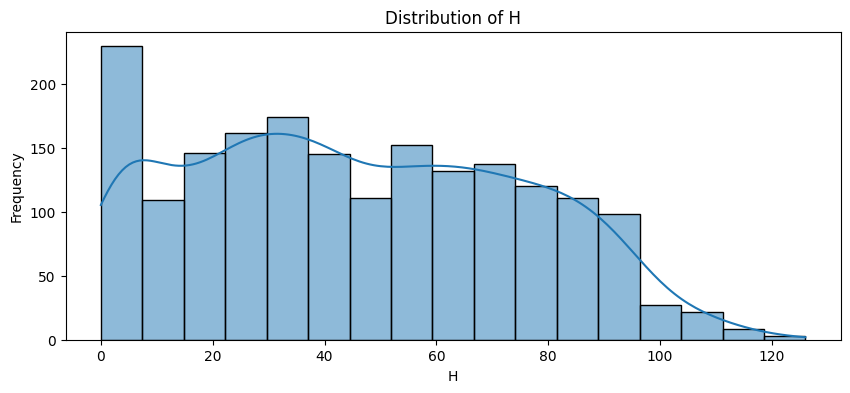

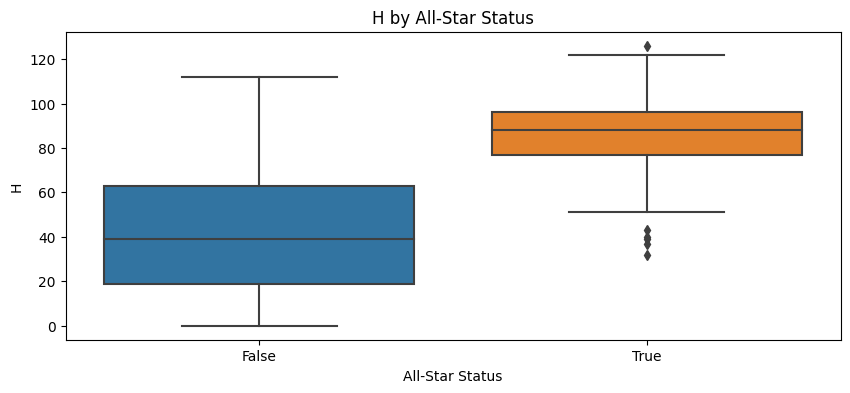

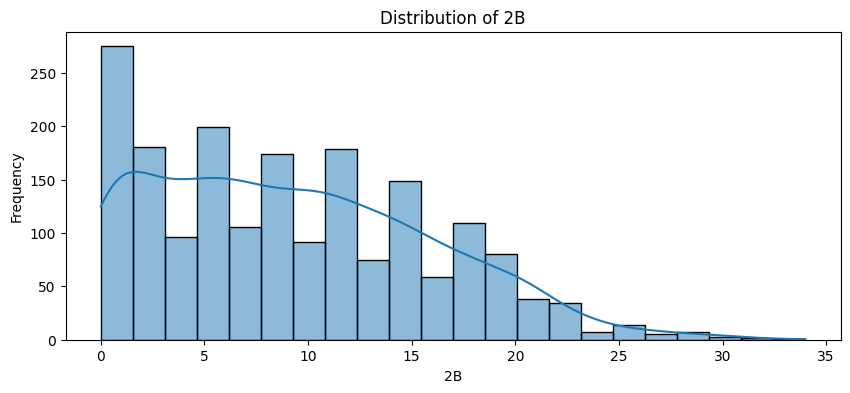

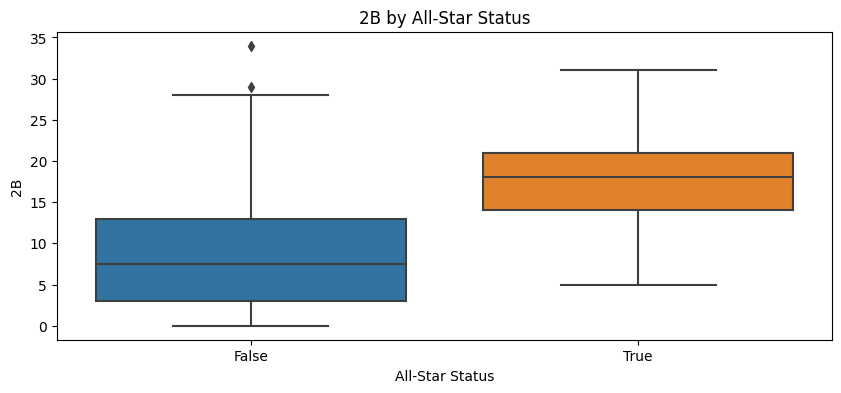

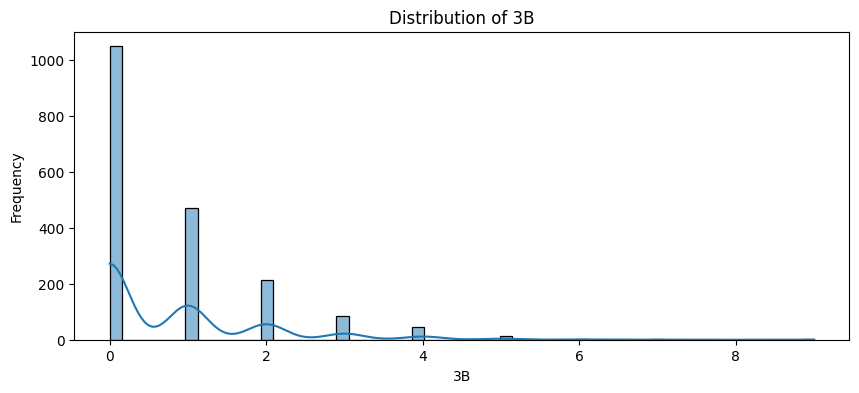

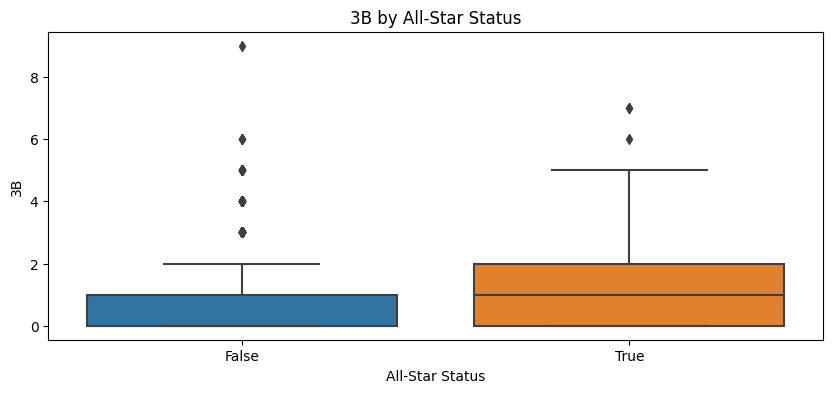

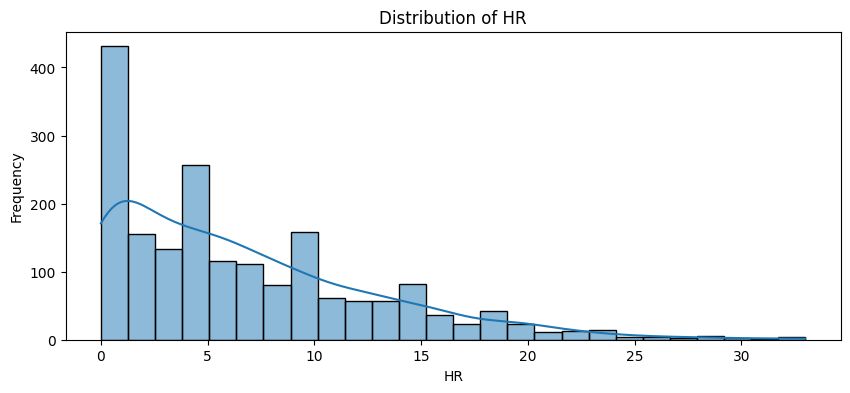

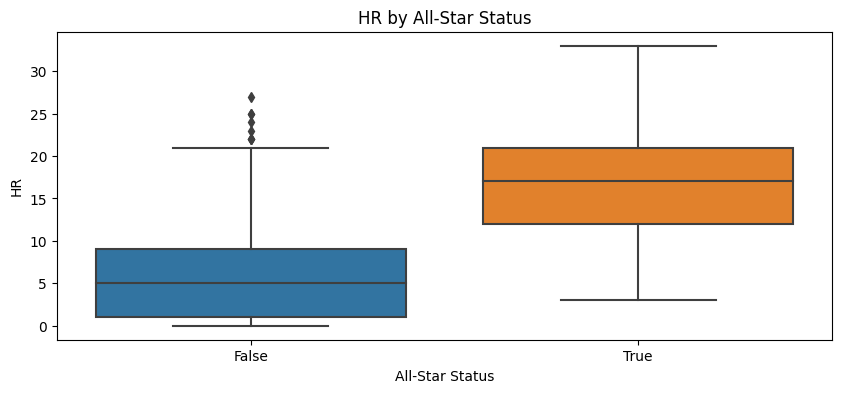

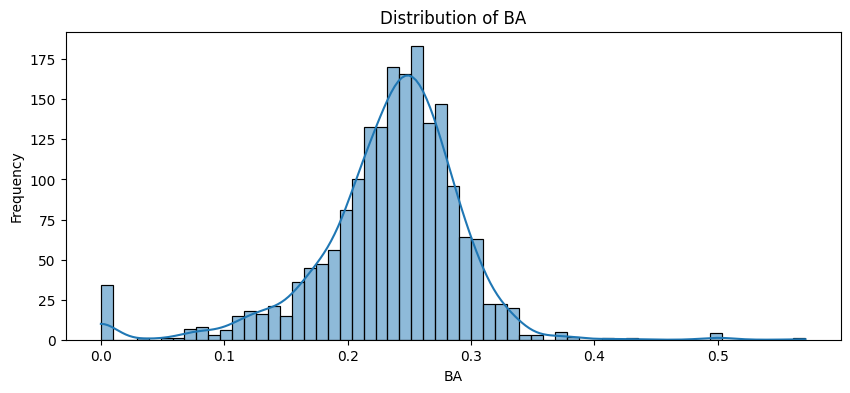

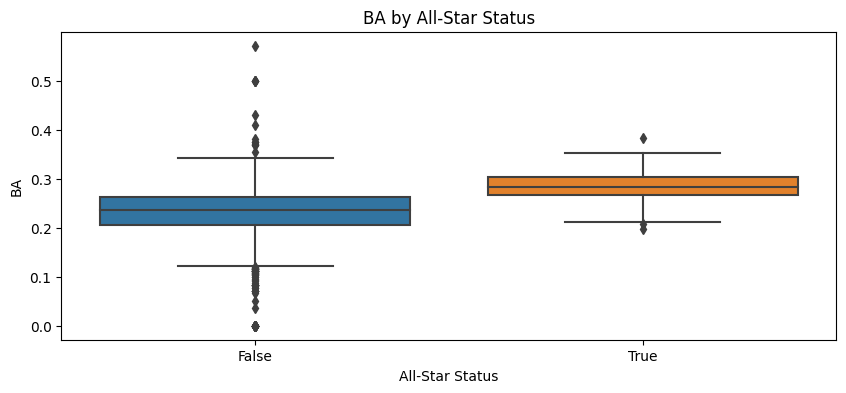

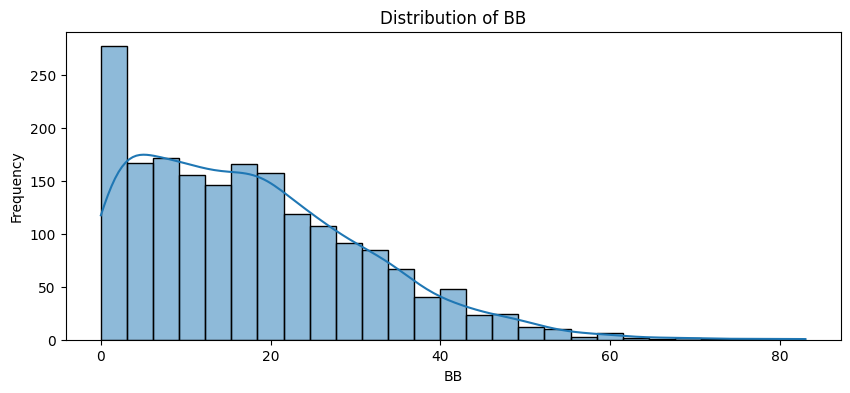

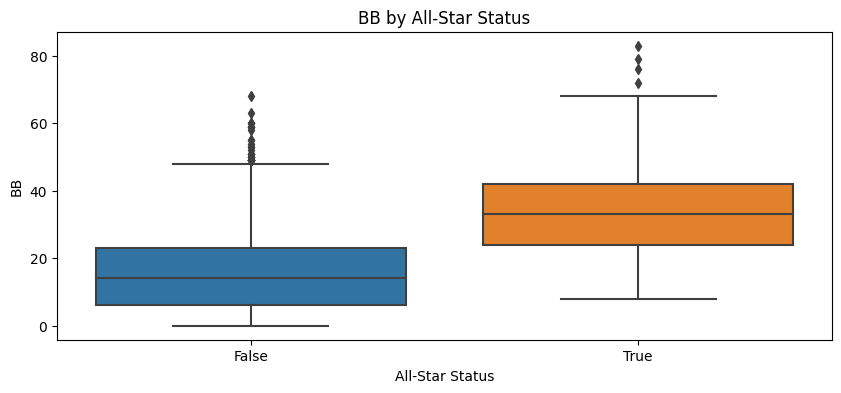

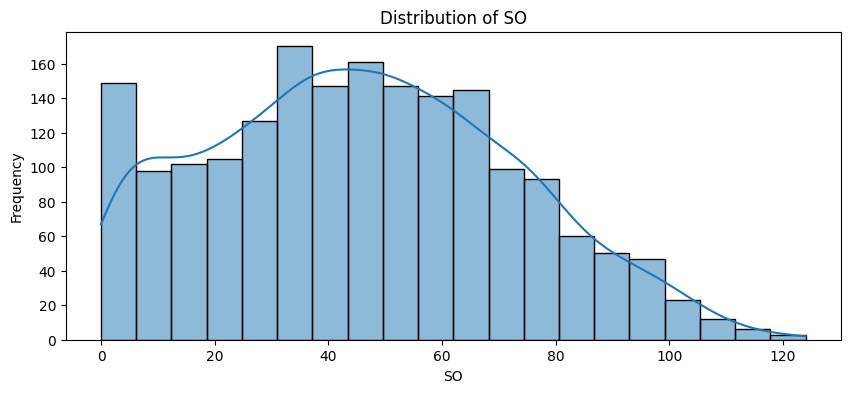

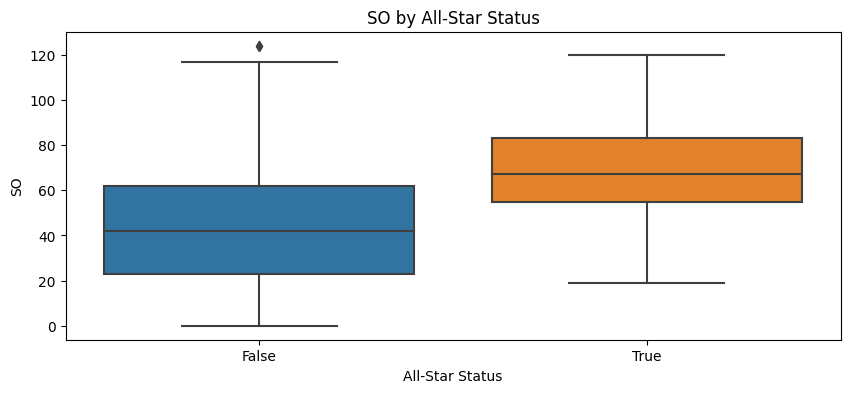

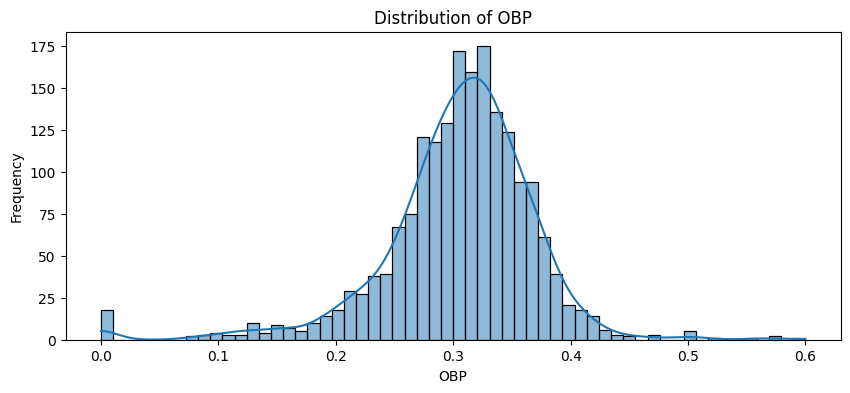

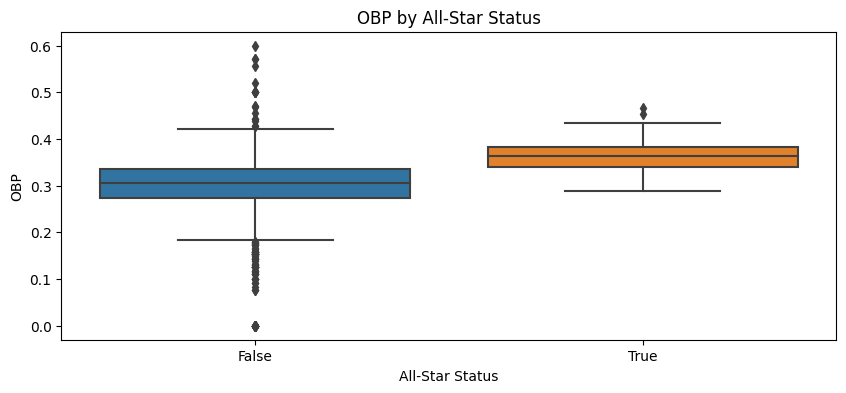

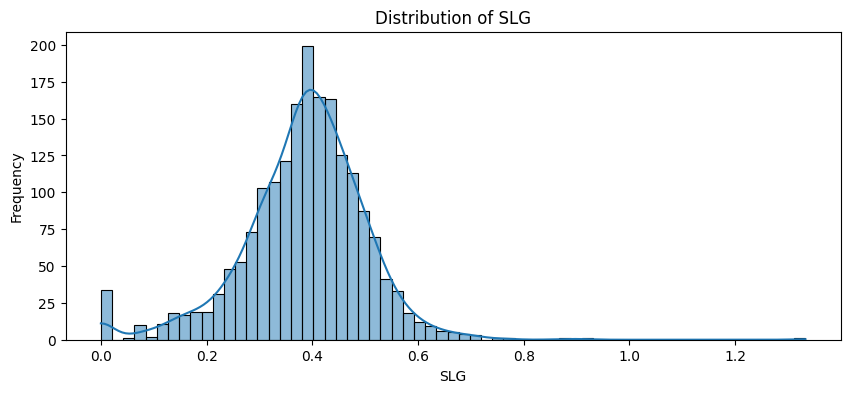

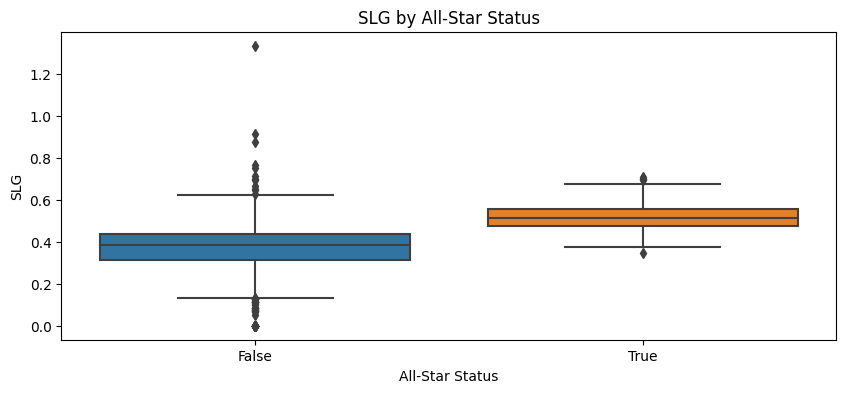

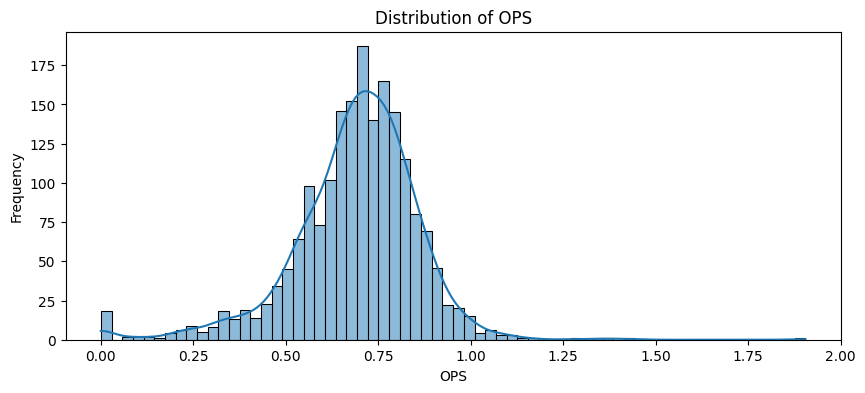

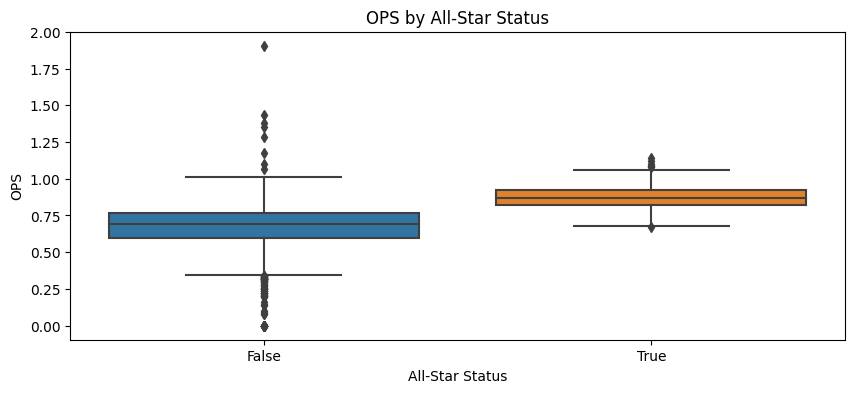

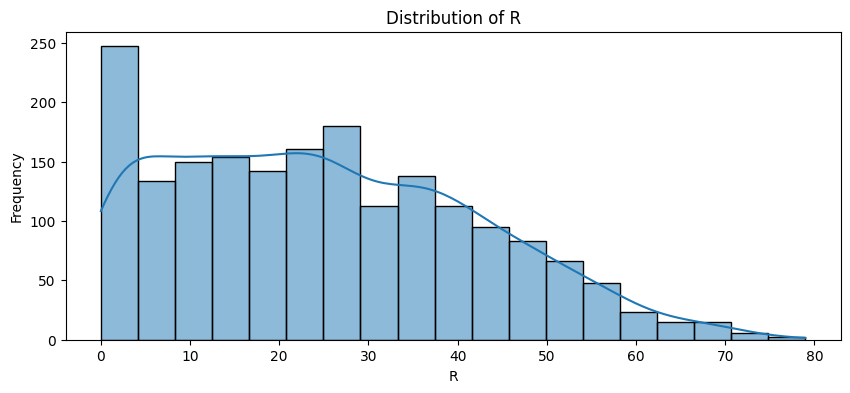

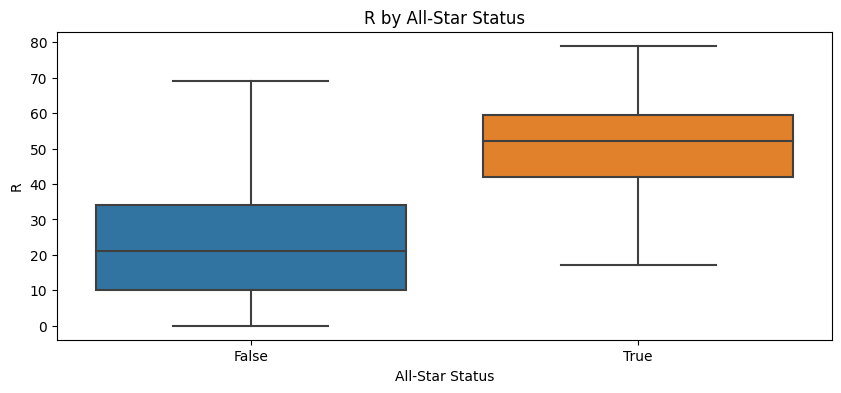

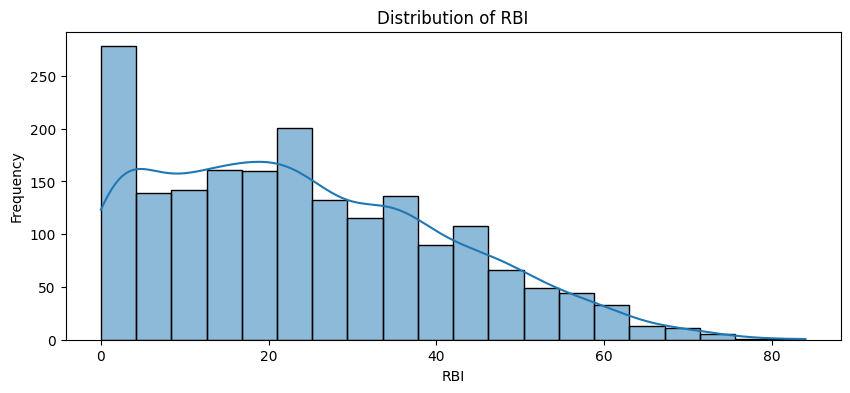

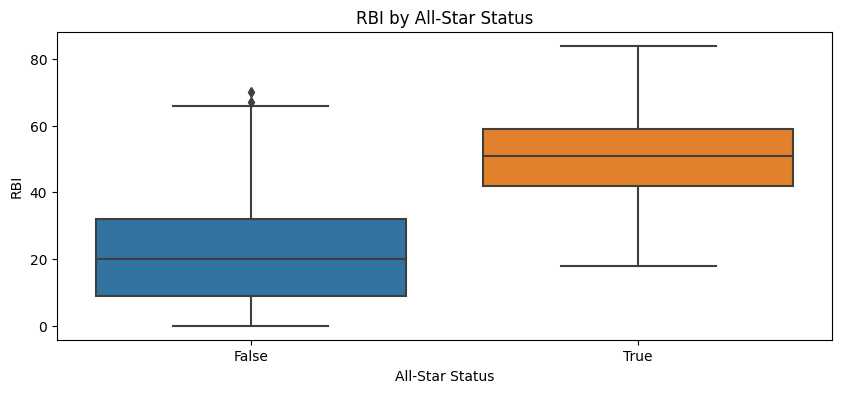

In [ ]:
create_plots(general_statistics_variables, final)

### Advanced Statistics Plots

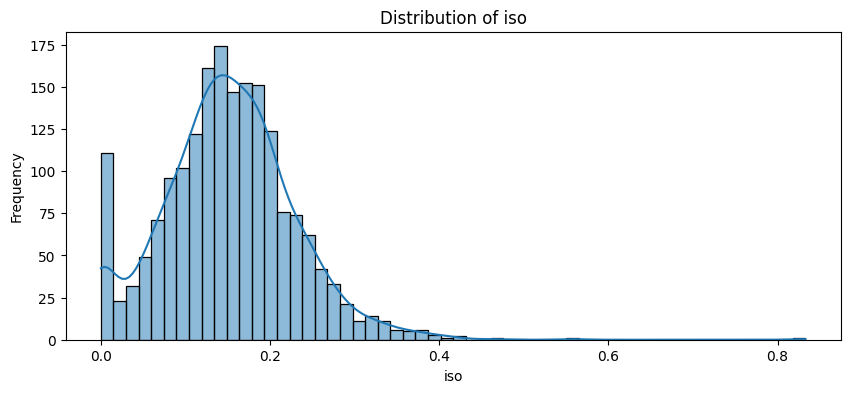

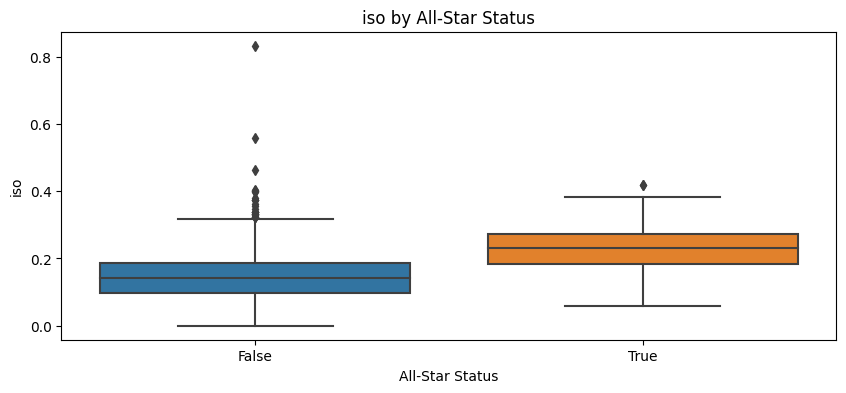

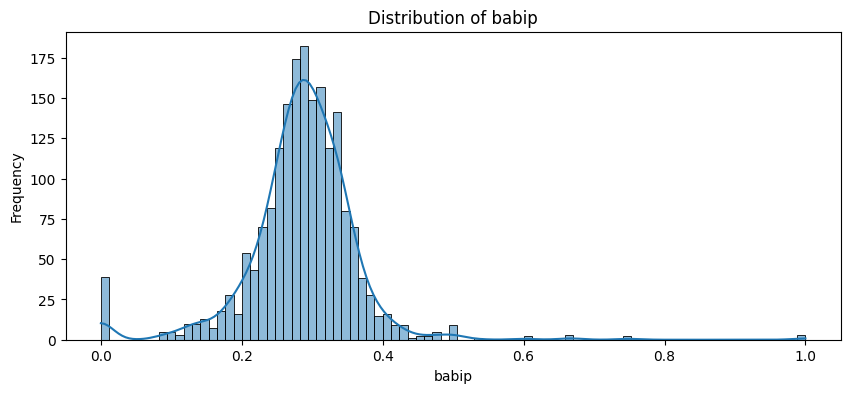

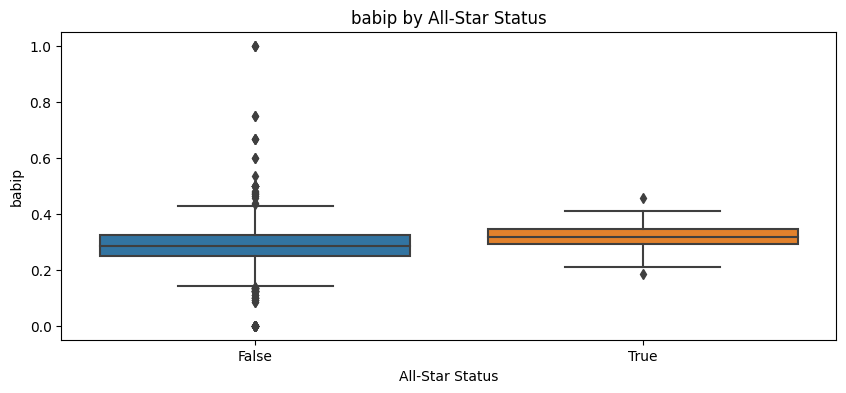

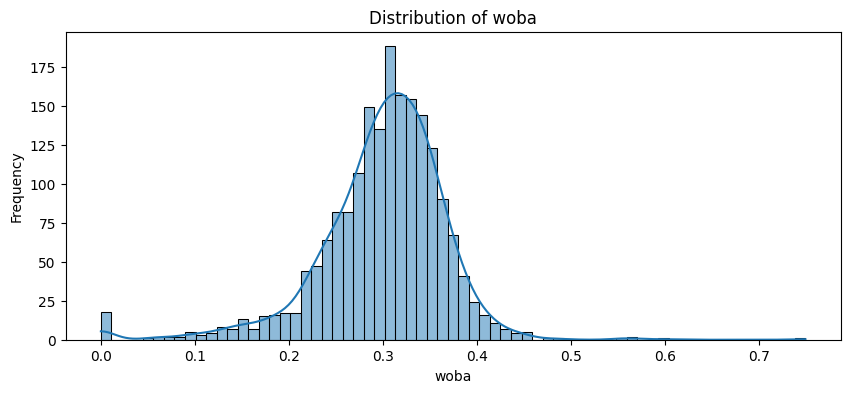

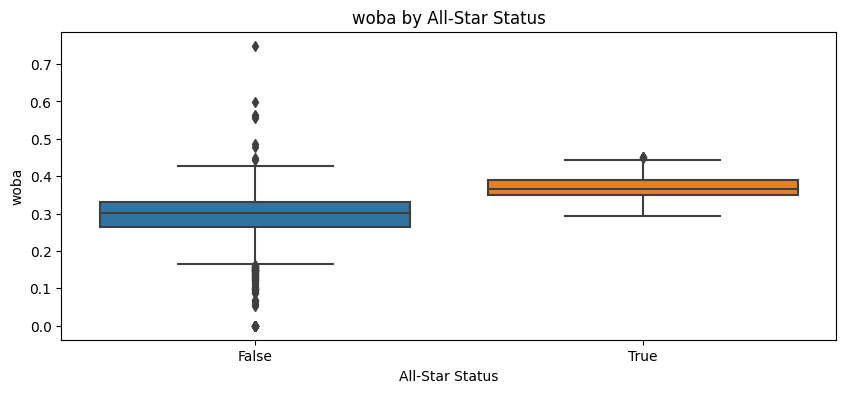

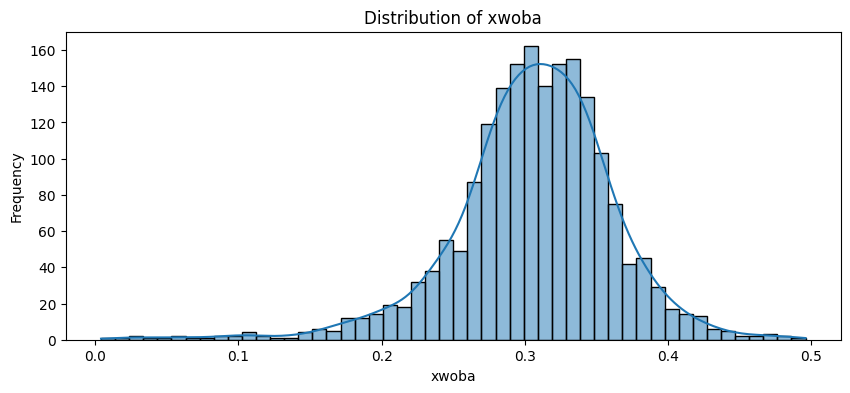

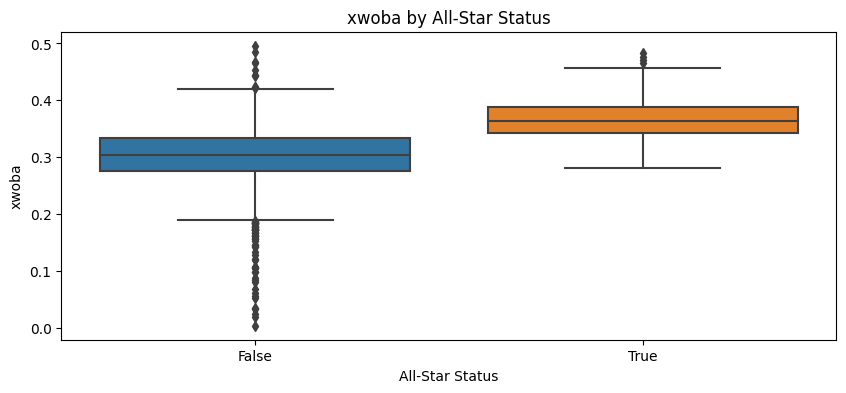

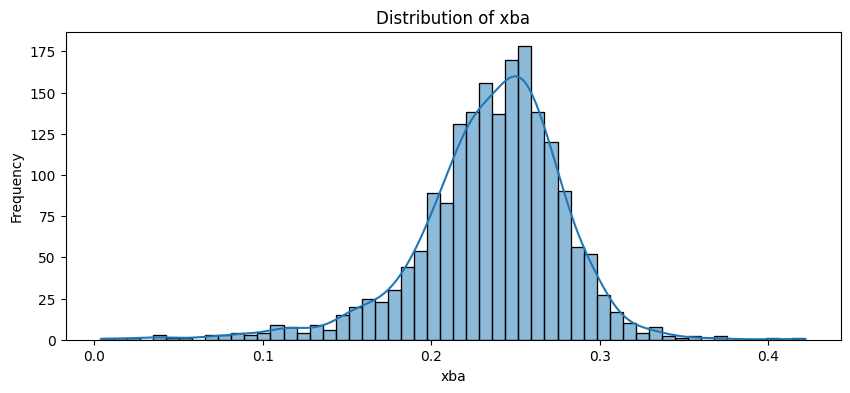

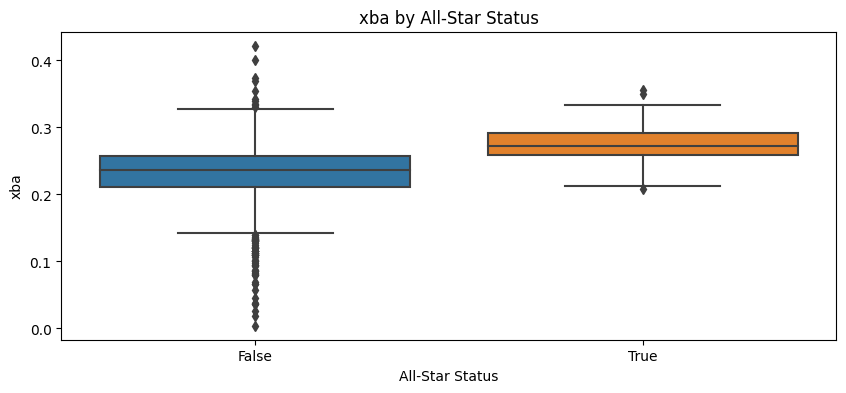

In [ ]:
create_plots(advanced_statistics_variables, final)

## Age and All-Star Status

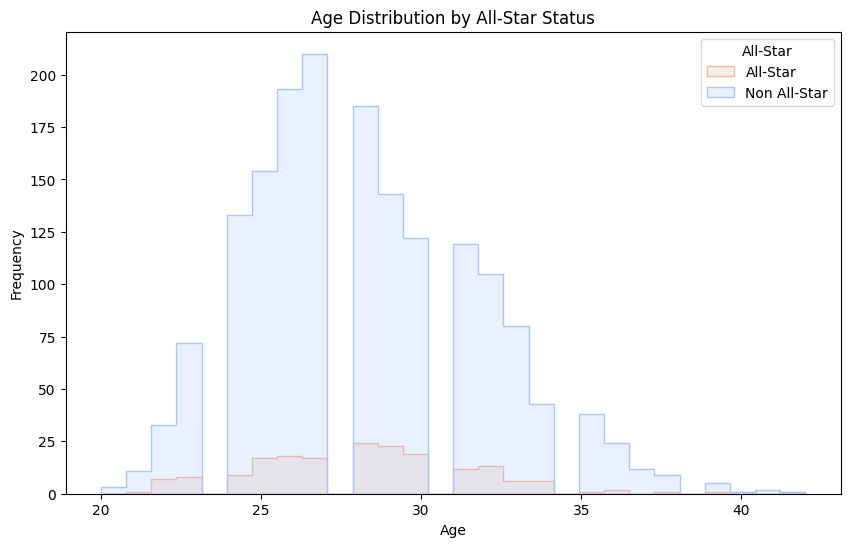

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=final, x='Age', hue='all_star', element='step', palette='coolwarm')
plt.title('Age Distribution by All-Star Status')
plt.xlabel('Age')
plt.ylabel('Frequency')

labels = ['All-Star', 'Non All-Star']
plt.legend(title='All-Star', labels=labels)

plt.show()

## Correlation Plots

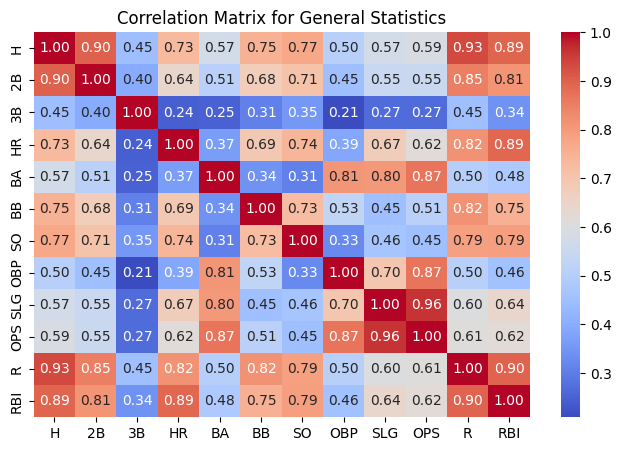

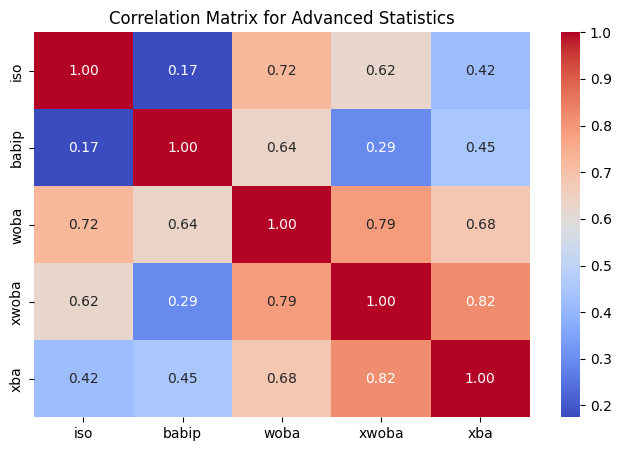

In [ ]:
plt.figure(figsize=(8, 5))
sns.heatmap(final[general_statistics_variables].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for General Statistics')
plt.show()

plt.figure(figsize=(8, 5))
sns.heatmap(final[advanced_statistics_variables].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Advanced Statistics')
plt.show()


## ANOVA Test to Find Potential Statistically Significance between Groups

In [ ]:
variables_to_test = ['BA', 'babip', 'woba', 'RBI', 'OPS', 'HR']

anova_results = {}

for variable in variables_to_test:
    model = ols(f'{variable} ~ C(all_star)', data=final).fit()
    anova_results[variable] = sm.stats.anova_lm(model, typ=2)

for variable, results in anova_results.items():
    print(f"ANOVA results for {variable} against all_star:\n", results, "\n")


ANOVA results for BA against all_star:
                sum_sq      df           F        PR(>F)
C(all_star)  0.544887     1.0  165.113157  2.757333e-36
Residual     6.214051  1883.0         NaN           NaN 

ANOVA results for babip against all_star:
                 sum_sq      df         F        PR(>F)
C(all_star)   0.214962     1.0  33.50307  8.316314e-09
Residual     12.081665  1883.0       NaN           NaN 

ANOVA results for woba against all_star:
                sum_sq      df           F        PR(>F)
C(all_star)  1.064011     1.0  269.749314  9.378089e-57
Residual     7.427384  1883.0         NaN           NaN 

ANOVA results for RBI against all_star:
                     sum_sq      df           F         PR(>F)
C(all_star)  139893.330700     1.0  635.134085  5.232643e-121
Residual     414745.717576  1883.0         NaN            NaN 

ANOVA results for OPS against all_star:
                 sum_sq      df          F        PR(>F)
C(all_star)   7.477503     1.0  300.47943 

# Machine Learning Model

## Data Preparation

In [ ]:
X = final.drop(['all_star', 'player_id', 'player_name', 'Tm', 'Lev', 'Age'], axis=1)
y = final['all_star']

In [ ]:
X.head()

,iso,babip,woba,xwoba,xba,whiffs,swings,takes,G,PA,...,SF,GDP,SB,CS,BA,OBP,SLG,OPS,Year,abbr
0,0.315,0.280,0.388,0.390,0.253,259,829,894,89,400,...,1,8,1,0,0.254,0.358,0.569,0.926,2023,ATL
1,0.152,0.327,0.341,0.341,0.269,147,740,940,90,411,...,3,11,0,0,0.270,0.360,0.421,0.781,2023,TEX
2,0.161,0.280,0.329,0.343,0.253,135,655,995,91,404,...,6,11,12,2,0.250,0.339,0.411,0.750,2023,CIN
3,0.140,0.329,0.340,0.343,0.241,191,726,917,87,377,...,3,6,7,2,0.247,0.377,0.386,0.763,2023,CHC
4,0.176,0.325,0.353,0.352,0.257,170,698,942,88,401,...,3,2,3,1,0.266,0.365,0.442,0.807,2023,NYM


In [ ]:
y.head()

0     True
1    False
2    False
3    False
4    False
Name: all_star, dtype: bool

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_final = final.copy()
num_attribs = list(X_train.select_dtypes(include=[np.number]))
cat_attribs = list(X_train.select_dtypes(exclude=[np.number]))

print(num_attribs)
print(cat_attribs)

pre_processing_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X_train_prepared = pre_processing_pipeline.fit_transform(X_train)
X_test_prepared = pre_processing_pipeline.transform(X_test)
X_final_prepared = pre_processing_pipeline.transform(X_final)

['iso', 'babip', 'woba', 'xwoba', 'xba', 'whiffs', 'swings', 'takes', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'SO', 'HBP', 'SH', 'SF', 'GDP', 'SB', 'CS', 'BA', 'OBP', 'SLG', 'OPS']
['Year', 'abbr']


## Model Training

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
svm_model = SVC(probability=True, random_state=42)
log_model = LogisticRegression(random_state=42)

dt_model.fit(X_train_prepared, y_train)
rf_model.fit(X_train_prepared, y_train)
gb_model.fit(X_train_prepared, y_train)
svm_model.fit(X_train_prepared, y_train)
log_model.fit(X_train_prepared, y_train)

LogisticRegression(random_state=42)

## Model Evaluation

In [ ]:
dt_predictions = dt_model.predict(X_test_prepared)
rf_predictions = rf_model.predict(X_test_prepared)
gb_predictions = gb_model.predict(X_test_prepared)
svm_predictions = svm_model.predict(X_test_prepared)
log_predictions = log_model.predict(X_test_prepared)

dt_accuracy = accuracy_score(y_test, dt_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)
gb_accuracy = accuracy_score(y_test, gb_predictions)
svm_accuracy = accuracy_score(y_test, svm_predictions)
log_accuracy = accuracy_score(y_test, log_predictions)

print(f"Accuracy of Decision Tree: {dt_accuracy:.4f}")
print(f"Accuracy of Random Forest: {rf_accuracy:.4f}")
print(f"Accuracy of Gradient Boosting Regression: {gb_accuracy:.4f}")
print(f"Accuracy of Support Vector Machine Regression: {svm_accuracy:.4f}")
print(f"Accuracy of Logistic Regression: {log_accuracy:.4f}")

Accuracy of Decision Tree: 0.9178
Accuracy of Random Forest: 0.9602
Accuracy of Gradient Boosting Regression: 0.9602
Accuracy of Support Vector Machine Regression: 0.9576
Accuracy of Logistic Regression: 0.9496


Gradient Boosting Regression yielded the highest accuracy score, thus we will go form and focus on this type of model

## Feature Importance Analysis

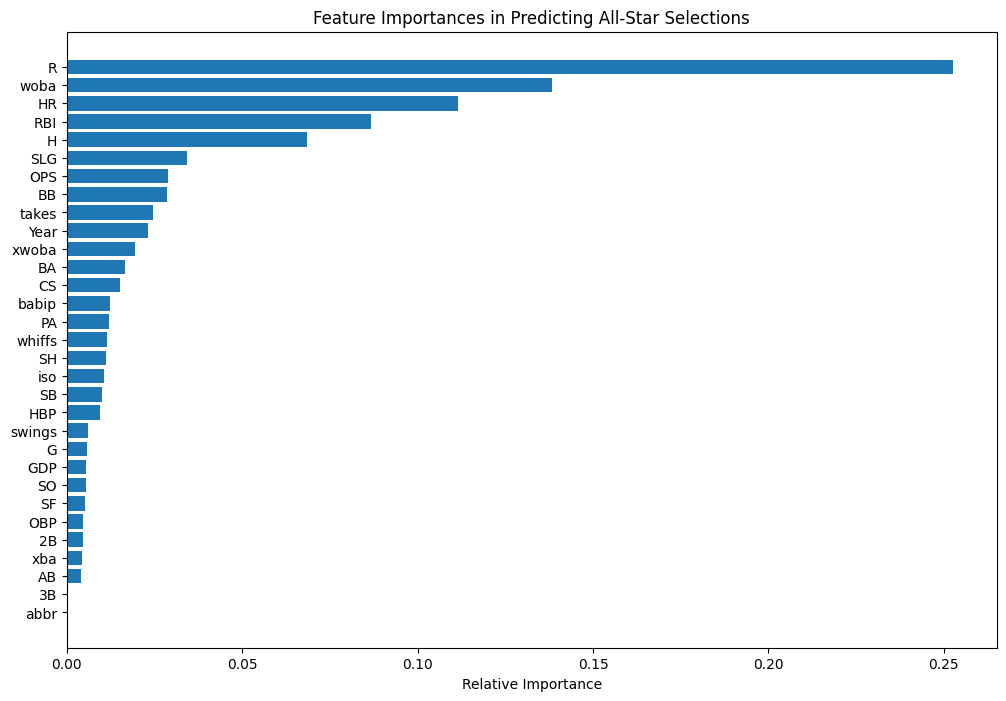

In [ ]:
importances = gb_model.feature_importances_

all_features = num_attribs + cat_attribs

# Map importances to their corresponding feature names
feature_importances = sorted(zip(importances, all_features), reverse=True)

importances_df = pd.DataFrame(feature_importances, columns=['importance', 'feature']).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.title("Feature Importances in Predicting All-Star Selections")
plt.barh(importances_df['feature'], importances_df['importance'])
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.xlabel('Relative Importance')
plt.show()

## Final Predictions and Prediction Analysis

In [ ]:
final_predictions = gb_model.predict(X_final_prepared)

final_positives = final.copy()

final_positives['predicted_all_star'] = final_predictions

def categorize_prediction(row):
    if row['all_star'] == True and row['predicted_all_star'] == True:
        return 'True Positive'
    elif row['all_star'] == False and row['predicted_all_star'] == True:
        return 'False Positive'
    elif row['all_star'] == False and row['predicted_all_star'] == False:
        return 'True Negative'
    elif row['all_star'] == True and row['predicted_all_star'] == False:
        return 'False Negative'

final_positives['prediction_analysis'] = final_positives.apply(categorize_prediction, axis=1)

In [ ]:
final_positives.head()

,player_id,player_name,iso,babip,woba,xwoba,xba,whiffs,swings,takes,...,CS,BA,OBP,SLG,OPS,Year,all_star,abbr,predicted_all_star,prediction_analysis
0,621566,Matt Olson,0.315,0.280,0.388,0.390,0.253,259,829,894,...,0,0.254,0.358,0.569,0.926,2023,True,ATL,True,True Positive
1,663993,Nathaniel Lowe,0.152,0.327,0.341,0.341,0.269,147,740,940,...,0,0.270,0.360,0.421,0.781,2023,False,TEX,False,True Negative
2,663697,Jonathan India,0.161,0.280,0.329,0.343,0.253,135,655,995,...,2,0.250,0.339,0.411,0.750,2023,False,CIN,False,True Negative
3,664023,Ian Happ,0.140,0.329,0.340,0.343,0.241,191,726,917,...,2,0.247,0.377,0.386,0.763,2023,False,CHC,False,True Negative
4,607043,Brandon Nimmo,0.176,0.325,0.353,0.352,0.257,170,698,942,...,1,0.266,0.365,0.442,0.807,2023,False,NYM,False,True Negative


In [ ]:
final_positives['prediction_analysis'].value_counts()

True Negative     1693
True Positive      160
False Negative      27
False Positive       5
Name: prediction_analysis, dtype: int64

##  False Positives

In [ ]:
false_positive_snubs = final_positives[final_positives['prediction_analysis'].str.contains('False Positive')]
false_positive_snubs

,player_id,player_name,iso,babip,woba,xwoba,xba,whiffs,swings,takes,...,CS,BA,OBP,SLG,OPS,Year,all_star,abbr,predicted_all_star,prediction_analysis
32,650402,Gleyber Torres,0.162,0.262,0.322,0.348,0.272,151,699,815,...,5,0.252,0.325,0.413,0.739,2023,False,NYY,True,False Positive
44,646240,Rafael Devers,0.240,0.267,0.345,0.380,0.277,210,782,681,...,1,0.254,0.325,0.493,0.818,2023,False,BOS,True,False Positive
45,519203,Anthony Rizzo,0.274,0.210,0.360,0.358,0.242,137,629,792,...,2,0.224,0.344,0.498,0.842,2022,False,NYY,True,False Positive
7,467793,Carlos Santana,0.175,0.252,0.344,0.362,0.246,155,658,879,...,0,0.246,0.368,0.421,0.789,2021,False,KC,True,False Positive
16,571745,Mitch Haniger,0.230,0.291,0.340,0.345,0.262,200,704,775,...,0,0.260,0.314,0.490,0.803,2021,False,SEA,True,False Positive


## False Negatives

In [ ]:
false_negative_false_all_stars = final_positives[final_positives['prediction_analysis'].str.contains('False Negative')]
false_negative_false_all_stars

,player_id,player_name,iso,babip,woba,xwoba,xba,whiffs,swings,takes,...,CS,BA,OBP,SLG,OPS,Year,all_star,abbr,predicted_all_star,prediction_analysis
38,621020,Dansby Swanson,0.151,0.320,0.331,0.363,0.263,190,671,809,...,1,0.259,0.343,0.409,0.753,2023,True,CHC,False,False Negative
98,666971,Lourdes Gurriel Jr.,0.230,0.279,0.344,0.319,0.246,106,594,662,...,0,0.263,0.316,0.493,0.810,2023,True,ARI,False,False Negative
108,667670,Brent Rooker,0.238,0.310,0.352,0.347,0.239,225,569,659,...,0,0.246,0.341,0.485,0.826,2023,True,OAK,False,False Negative
115,521692,Salvador Perez,0.188,0.283,0.306,0.318,0.249,229,726,489,...,0,0.246,0.289,0.435,0.723,2023,True,KC,False,False Negative
130,553869,Elias Díaz,0.158,0.327,0.327,0.313,0.255,167,622,534,...,0,0.277,0.328,0.435,0.763,2023,True,COL,False,False Negative
141,669720,Austin Hays,0.185,0.389,0.364,0.338,0.263,142,516,620,...,1,0.314,0.355,0.498,0.853,2023,True,BAL,False,False Negative
161,606115,Orlando Arcia,0.131,0.348,0.336,0.308,0.250,124,495,548,...,0,0.294,0.345,0.425,0.769,2023,True,ATL,False,False Negative
26,593428,Xander Bogaerts,0.137,0.383,0.367,0.322,0.259,154,639,843,...,0,0.316,0.389,0.453,0.842,2022,True,BOS,False,False Negative
84,643265,Garrett Cooper,0.152,0.366,0.341,0.344,0.268,136,575,739,...,0,0.283,0.349,0.435,0.783,2022,True,MIA,False,False Negative
140,408234,Miguel Cabrera,0.059,0.369,0.294,0.289,0.253,165,572,571,...,0,0.287,0.324,0.346,0.670,2022,True,DET,False,False Negative


## Additional All-Star "Snub" Analysis

In [ ]:
probabilities = gb_model.predict_proba(X_final_prepared)
final_positives['all_star_probability'] = probabilities[:, 1]

all_star_threshold = 0.3

# Identify potential snubs
final_positives['potential_snub'] = (final_positives['all_star_probability'] >= all_star_threshold) & (final_positives['all_star'] == False)

In [ ]:
all_star_analysis_df = final_positives[['player_name', 'Year', 'predicted_all_star', 'all_star', 'prediction_analysis', 'all_star_probability', 'potential_snub']]
all_star_analysis_df.head()

,player_name,Year,predicted_all_star,all_star,prediction_analysis,all_star_probability,potential_snub
0,Matt Olson,2023,True,True,True Positive,0.970076,False
1,Nathaniel Lowe,2023,False,False,True Negative,0.145979,False
2,Jonathan India,2023,False,False,True Negative,0.100140,False
3,Ian Happ,2023,False,False,True Negative,0.010880,False
4,Brandon Nimmo,2023,False,False,True Negative,0.131043,False


In [ ]:
all_star_analysis_df.sort_values(by='all_star_probability', ascending = False)

,player_name,Year,predicted_all_star,all_star,prediction_analysis,all_star_probability,potential_snub
76,Rafael Devers,2022,True,True,True Positive,0.995824,False
35,Mookie Betts,2023,True,True,True Positive,0.995712,False
52,Vladimir Guerrero Jr.,2021,True,True,True Positive,0.995594,False
24,Austin Riley,2022,True,True,True Positive,0.994287,False
17,Shohei Ohtani,2023,True,True,True Positive,0.993487,False
...,...,...,...,...,...,...,...
276,Jordan Luplow,2022,False,False,True Negative,0.001996,False
558,Zach McKinstry,2022,False,False,True Negative,0.001996,False
562,Jerar Encarnación,2022,False,False,True Negative,0.001972,False
485,Mitch Haniger,2022,False,False,True Negative,0.001972,False


In [ ]:
all_snubs = all_star_analysis_df[all_star_analysis_df['potential_snub']].sort_values(by = 'all_star_probability', ascending = False)
all_snubs

,player_name,Year,predicted_all_star,all_star,prediction_analysis,all_star_probability,potential_snub
32,Gleyber Torres,2023,True,False,False Positive,0.884023,True
16,Mitch Haniger,2021,True,False,False Positive,0.702585,True
44,Rafael Devers,2023,True,False,False Positive,0.687930,True
45,Anthony Rizzo,2022,True,False,False Positive,0.659563,True
7,Carlos Santana,2021,True,False,False Positive,0.512570,True
212,Derek Dietrich,2019,False,False,True Negative,0.497706,True
75,Yordan Alvarez,2021,False,False,True Negative,0.490659,True
68,Ketel Marte,2023,False,False,True Negative,0.480866,True
133,Fernando Tatis Jr.,2023,False,False,True Negative,0.455515,True
44,Austin Riley,2021,False,False,True Negative,0.421187,True


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7560da13-e717-4617-8426-cdc9421fb65b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>